Actions each agent have to decide between: Leave or Stay 

In [1]:
import numpy as np

class Agent: 
    def __init__(self, music_taste = 1, strategy = 1, nr_concerts = 3, festival_duration=9):
        self.music_taste = music_taste
        self.position_utility = 0
        self.accumulated_position_utility = 0
        self.waiting_utility = 0
        self.strategy = strategy
        self.position_history = []
        self.concert_history = np.ones(festival_duration)*(nr_concerts-1)
        self.concert_history[0] = 0


    
class Concert:
    def __init__(self, len_rows = 1, music_type = 1, capacity = 5, duration = 2, nr_of_agents = 10):
        self.len_rows = len_rows
        self.music_type = music_type
        self.nr_agents = 0
        self.nr_waiting_agents = 0
        self.capacity = capacity
        self.nr_rows = np.ceil(capacity/len_rows)
        self.duration = duration #timesteps
        self.agents = np.zeros(nr_of_agents)

    def add_agent(self):
        self.nr_agents += 1

def get_placement_utility(concert):
    placement_factor = 5
    #continuing using sigmoid
    #fullness = concert.nr_agents / concert.capacity
    #sigmoid_x = 1 - fullness
    #k = 10 #steepness of sigomid
    #center = 0.5 #[0,1] with 0.1 happy crowd and 0.9 happy front row
    #utility = placement_factor * 1 / ( 1 + np.exp(-k*(sigmoid_x- center)))

    #stepwise by which row the agent is in, sensitive to concert row length
    dist_from_stage = np.floor((concert.nr_agents) / concert.len_rows)
    utility = placement_factor * (concert.nr_rows - dist_from_stage) / concert.nr_rows
    return utility

def get_time_at_concert_utility(agent):
    utility += agent

def get_waiting_utility(time):
    waiting_factor = 1
    utility = -time * waiting_factor
    return utility

Strategies: Sart with defining strategies that do not depend on any history. Deterministic depending on which timestep it likes to leave

In [2]:
def get_action(agent, timestep, max_time):
    # Stay at the consert
    if (agent.strategy == 1):
        if (timestep == max_time - 1):
            action = 'leave'
        else:
            action = 'stay'
        
    # Leave to the next concert as early as possible
    if (agent.strategy == 2):
        if (timestep == 0):
            action = 'leave'
        else:
            print("Leaving agent stayed")

    # The one that likes to skip concerts 
    if (agent.strategy == 3):
        if (timestep < 1):
            action = 'stay'
        else:
            action = 'skip'

    return action


Inintialize agents and concerts 

In [3]:
nr_of_agents = 100
agents = []

nr_concerts = 5
concert_duration = 3
festival_duration = nr_concerts*concert_duration
concerts = []

for _ in range (nr_of_agents):
    agents.append(Agent(music_taste=np.random.randint(1,4), strategy=np.random.randint(1,3), nr_concerts=nr_concerts, festival_duration = festival_duration))

for _ in range(nr_concerts):
    concerts.append(Concert(music_type=np.random.randint(1,3), capacity = nr_of_agents, duration = concert_duration, nr_of_agents = nr_of_agents))

#Add all agents to the starting concerts in a random order
shuffled_indices = np.random.permutation(nr_of_agents)
for i in range (nr_of_agents):
    idx = shuffled_indices[i]
    position_utility = 0 #get_placement_utility(concerts[0])
    concerts[0].add_agent() 
    concerts[0].agents[idx] = 1
    agents[idx].position_utility = position_utility
    agents[idx].accumulated_position_utility = position_utility
    concerts[0].add_agent() 


#TODO All agents leaving during the same timestep must get the same utility

In [4]:
def move_agent_to_next_concert(agent, idx, current_concert, next_concert, timestep):
    # Set agent up at the next concert
    agent.waiting_utility += get_waiting_utility(current_concert.duration - timestep) 
    position_utility = get_placement_utility(next_concert)
    next_concert.add_agent() 
    next_concert.agents[idx] = 1
    agent.position_utility = position_utility
    agent.accumulated_position_utility = position_utility

In [5]:
global_time = 0
for concert_idx in range(0,len(concerts)-1):
    current_concert = concerts[concert_idx]
    next_concert = concerts[concert_idx + 1]
    #next_next_concert = concerts[ i + 2]

    for timestep in range(0,current_concert.duration):
        # Update time
        global_time += 1
        shuffled_indices = np.random.permutation(nr_of_agents)
        for j in range (nr_of_agents):
            idx = shuffled_indices[j]
            
            if (current_concert.agents[idx] == 0):   
                continue
               
            action = get_action(agents[idx],timestep, current_concert.duration)
            
            if (action == 'leave'):
                # Save accumulated position utility for agent at curent concert
                agents[idx].position_history.append(agents[idx].accumulated_position_utility) 
                # Leave current concert
                current_concert.agents[idx] = 0
                
                for k in range(0,current_concert.duration-timestep):
                    #Update agent's concert history
                    #SOMETHING GOES WRONG HERE
                    agents[idx].concert_history[global_time + k] = concert_idx + 1

                # Set agent up at the next concert
                move_agent_to_next_concert(agents[idx], idx, current_concert, next_concert, timestep)
                
            else: #they stay at the concert one more time step
                agents[idx].accumulated_position_utility += agents[idx].position_utility
                #Update agent's concert history
                agents[idx].concert_history[global_time] = concert_idx 
                
        

In [6]:
idx = 0
if ((agents[idx].strategy) == 2):
    print(agents[idx].strategy)
    print(len(agents[idx].concert_history))
    print(agents[idx].concert_history)

In [7]:
 # elif (action == 'skip'):
            #     agents[idx].position_history.append(agents[idx].accumulated_position_utility) #rätt tillfälle?
            #     agents[idx].waiting_utility += get_waiting_utility(next_next_concert.duration)
            #     position_utility = get_placement_utility(next_next_concert)
            #     next_next_concert.add_agent() 
            #     next_next_concert.agents[idx] = 1
            #     agents[idx].position_utility = position_utility
            #     agents[idx].accumulated_position_utility = position_utility
            #     current_concert.agents[idx] = 0
            #     #Update agent's concert history
            #     agents[idx].concert_history.append(i+2) #does not work
                

How did the simulation go?

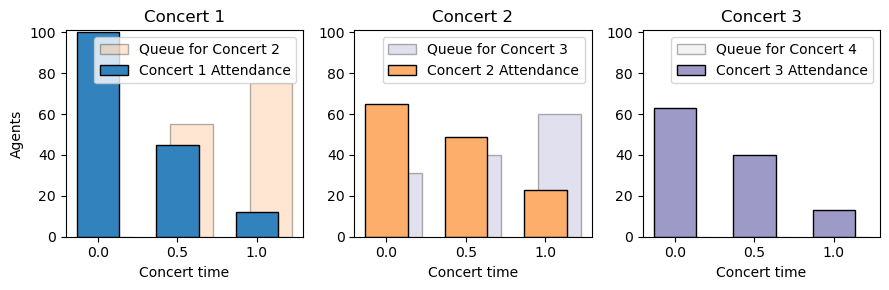

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [8]:
from graphs import BarGraph
A = np.zeros([nr_concerts, int(nr_concerts*concerts[0].duration)])

agent_concert = []

# Make dataset
for agent in agents:
    agent_concert.append(agent.concert_history)

for agent in agent_concert:
    t = 0
    for i in agent:
        A[i, t] += 1
        t += 1

graph = BarGraph(A)
graph.plot_data(5)

In [ ]:
sorted_agents = sorted(agents, key=lambda agent: sum(agent.position_history) + agent.waiting_utility, reverse=True)
for i in range (nr_of_agents):
    print("Utility: ", sum(sorted_agents[i].position_history) + sorted_agents[i].waiting_utility, ", Strategy: ", sorted_agents[i].strategy)

Utility:  5.3500000000000005 , Strategy:  1
Utility:  5.199999999999999 , Strategy:  1
Utility:  5.050000000000001 , Strategy:  1
Utility:  4.8999999999999995 , Strategy:  1
Utility:  4.75 , Strategy:  1
Utility:  4.6000000000000005 , Strategy:  1
Utility:  4.449999999999999 , Strategy:  1
Utility:  4.300000000000001 , Strategy:  1
Utility:  4.1499999999999995 , Strategy:  1
Utility:  4.0 , Strategy:  1
Utility:  3.8499999999999996 , Strategy:  1
Utility:  3.6999999999999993 , Strategy:  1
Utility:  3.5500000000000007 , Strategy:  1
Utility:  3.4000000000000004 , Strategy:  1
Utility:  3.25 , Strategy:  1
Utility:  3.0999999999999996 , Strategy:  1
Utility:  2.9499999999999993 , Strategy:  1
Utility:  2.8000000000000007 , Strategy:  1
Utility:  2.6500000000000004 , Strategy:  1
Utility:  2.5 , Strategy:  1
Utility:  2.3499999999999996 , Strategy:  1
Utility:  2.1999999999999993 , Strategy:  1
Utility:  2.0500000000000007 , Strategy:  1
Utility:  1.9000000000000004 , Strategy:  1
Utilit